In [1]:
#Loading packages for prediction
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

### Missing Values
Before we go on to build the model, we must look for missing values within the dataset as treating the missing values is a necessary step before we fit a logistic regression model on the dataset.

In [3]:
pd.isnull(df).sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

This shows that everything is fine and there is nothing to change in terms of the data.

### Preprocessing

Now, before applying linear model such as logistic regression, we need to scale the data and keep all features as numeric strictly. (Some of them from EDA)


In [4]:
#Distance calculation
from geopy import distance
from tqdm import tqdm_notebook as tqdm

df['pickup_loc']=df['pickup_latitude'].map(str)+","+df['pickup_longitude'].map(str)
df['drop_loc']=df['dropoff_latitude'].map(str)+","+df['dropoff_longitude'].map(str)

temp = []

for i in tqdm(range(0,len(df.id))):
    temp.append(distance.distance(df.pickup_loc[i],df.drop_loc[i]).km)

df['distance in km']=temp

In [5]:
#Convert store_and_fwd_flag
dict_flag = {'Y': 1, 'N':0}
df.replace({'store_and_fwd_flag': dict_flag}, inplace = True)

In [6]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance in km
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05,729322.000000
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,0.005539,9.522291e+02,3.442464
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,0.074221,3.864626e+03,4.356668
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,0.000000,1.000000e+00,0.000000
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,0.000000,3.970000e+02,1.233153
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,0.000000,6.630000e+02,2.096073
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,0.000000,1.075000e+03,3.875828
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.000000,1.939736e+06,1240.510256


### Outlier Treatment

Focusing on the trip duration and distance. (Firstly dealing with distance)

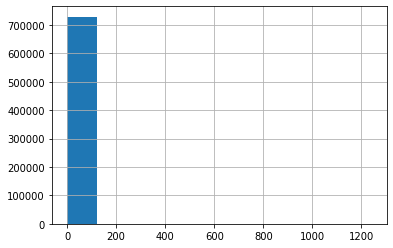

In [7]:
%matplotlib inline
(df['distance in km']).hist()

In [8]:
IQR_dist = df['distance in km'].quantile(0.75) - df['distance in km'].quantile(0.25)
Q1_dist = df['distance in km'].quantile(0.25)
Q3_dist = df['distance in km'].quantile(0.75)

whisker_1_dist = Q1_dist - (1.5*IQR_dist)
whisker_2_dist = Q3_dist + (1.5*IQR_dist)

whisker_1_dist, whisker_2_dist

(-2.730859074419591, 7.839840348422177)

In [9]:
#Deleting the outliers in distance
df1 = df.loc[df['distance in km']<8]
df.shape, df1.shape

((729322, 14), (660778, 14))

In [10]:
#Replacing the zeroes (as it doesn't make sense to have a trip with 0 km)
df1['distance in km'].loc[df1['distance in km']==0] = Q1_dist

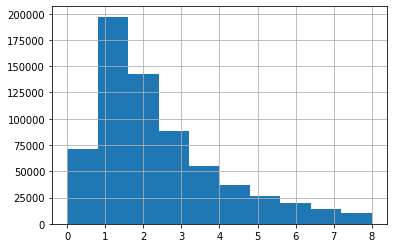

In [11]:
#Lets take a look now
%matplotlib inline
(df1['distance in km']).hist()

Now dealing with duration.

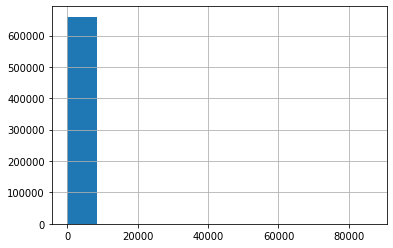

In [12]:
%matplotlib inline
(df1['trip_duration']).hist()

In [13]:
#Deleting the outliers in trip duration
IQR_duration = df1['trip_duration'].quantile(0.75) - df1['trip_duration'].quantile(0.25)
Q1_duration = df1['trip_duration'].quantile(0.25)
Q3_duration = df1['trip_duration'].quantile(0.75)

whisker_1_duration = Q1_duration - (1.5*IQR_duration)
whisker_2_duration = Q3_duration + (1.5*IQR_duration)

whisker_1_duration, whisker_2_duration

(-467.5, 1776.5)

In [14]:
#Deleting the outliers in distance
df2 = df1.loc[df1['trip_duration']<1776.5]
df1.shape, df2.shape

((660778, 14), (640482, 14))

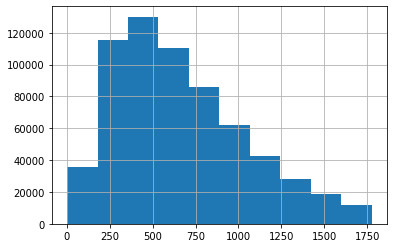

In [15]:
#Lets take a look now
(df2['trip_duration']).hist()

Let's square root it to make it more symmetrical

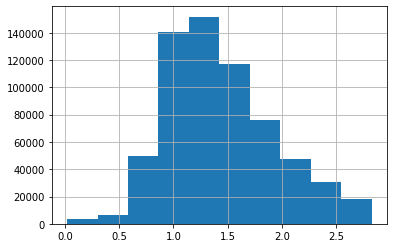

In [16]:
np.sqrt(df2['distance in km']).hist()

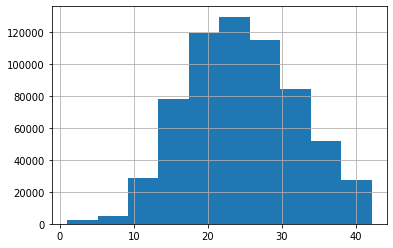

In [17]:
np.sqrt(df2['trip_duration']).hist()

In [18]:
df2.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance in km
count,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000
mean,1.533515,1.656930,-73.979475,40.752931,-73.977578,40.753214,0.004789,662.577164,2.317043
std,0.498876,1.310329,0.065454,0.025528,0.065910,0.027982,0.069034,377.727420,1.590268
min,1.000000,0.000000,-121.933342,37.389381,-121.933304,37.389511,0.000000,1.000000,0.000424
25%,1.000000,1.000000,-73.992126,40.738636,-73.991592,40.738136,0.000000,367.000000,1.160635
50%,2.000000,1.000000,-73.982185,40.754322,-73.980675,40.754852,0.000000,591.000000,1.857709
75%,2.000000,2.000000,-73.969566,40.767757,-73.966339,40.769352,0.000000,896.000000,3.032985
max,2.000000,9.000000,-65.897385,43.911762,-65.897385,43.911762,1.000000,1776.000000,7.999906


In [19]:
df2['pickup_datetime'] = pd.to_datetime(df2['pickup_datetime'])
df2['dropoff_datetime'] = pd.to_datetime(df2['dropoff_datetime'])

In [20]:
#Extract the hour
def hr_func(ts):
    return ts.hour

df2['p_hour'] = df2['pickup_datetime'].apply(hr_func)
df2['d_hour'] = df2['dropoff_datetime'].apply(hr_func)

In [21]:
#Extracting the day as Mond = 1 and Sunday = 7
df2['day'] = df2['pickup_datetime'].dt.day_name()
df2['day'] = df2['day'].astype(str)
dict_day = {'Monday': 1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 
            'Sunday': 7}
df2.replace({'day': dict_day}, inplace = True)

* Won't be extracting the months or years as it probably won't be as influential as hours and days

In [22]:
#Dropping all the useless columns i.e. non-numerical columns
df2 = df2.drop(['id','pickup_datetime','dropoff_datetime','pickup_loc','drop_loc'], axis=1)

In [23]:
df2.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance in km,p_hour,d_hour,day
count,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000,640482.000000
mean,1.533515,1.656930,-73.979475,40.752931,-73.977578,40.753214,0.004789,662.577164,2.317043,13.647355,13.647854,4.059660
std,0.498876,1.310329,0.065454,0.025528,0.065910,0.027982,0.069034,377.727420,1.590268,6.388625,6.454237,1.957437
min,1.000000,0.000000,-121.933342,37.389381,-121.933304,37.389511,0.000000,1.000000,0.000424,0.000000,0.000000,1.000000
25%,1.000000,1.000000,-73.992126,40.738636,-73.991592,40.738136,0.000000,367.000000,1.160635,9.000000,9.000000,2.000000
50%,2.000000,1.000000,-73.982185,40.754322,-73.980675,40.754852,0.000000,591.000000,1.857709,14.000000,14.000000,4.000000
75%,2.000000,2.000000,-73.969566,40.767757,-73.966339,40.769352,0.000000,896.000000,3.032985,19.000000,19.000000,6.000000
max,2.000000,9.000000,-65.897385,43.911762,-65.897385,43.911762,1.000000,1776.000000,7.999906,23.000000,23.000000,7.000000


# Regression Benchmark Model
Since energy output is continuous and not a classification problem

In [24]:
from sklearn.utils import shuffle

# Shuffling the Dataset
data = shuffle(df2, random_state = 56)

#creating 4 divisions
div = int(df2.shape[0]/4)

# 3 parts to train set and 1 part to test set
train = df2.iloc[:3*div+1,:]
test = df2.iloc[3*div+1:]
train.shape, test.shape, data.shape

((480361, 12), (160121, 12), (640482, 12))

In [25]:
# storing simple mean in a new column in the test set as "simple_mean"
test['simple_mean'] = train['trip_duration'].mean()

In [26]:
#calculating mean absolute error
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

def adjusted_r_squared(clf,X,y):
    n = X.shape[0]
    p = X.shape[1]
    r_squared = r2_score(y,clf.predict(X))

simple_mae = MAE(test['trip_duration'] , test['simple_mean'])
print(simple_mae)
simple_r2_score = r2_score(test['trip_duration'], test['simple_mean'])
print(simple_r2_score)

307.59633198685236
-4.584592163903167e-06


## Mean Energy output with respect to Days

In [27]:
out_day = pd.pivot_table(train, values='trip_duration', index = ['day'], aggfunc=np.mean)
out_day

,trip_duration
day,
1,630.428525
2,676.939031
3,689.141552
4,690.953364
5,682.144840
6,652.239930
7,606.939920


In [28]:
# initializing new column to zero
test['day_mean'] = 0

# For every unique entry day
for i in train['day'].unique():
  # Assign the mean value corresponding to unique entry
  test['day_mean'][test['day'] == i] = train['trip_duration'][train['day'] == i].mean()

In [29]:
#calculating mean absolute error
out_day_mae = MAE(test['trip_duration'] , test['day_mean'] )
print(out_day_mae)
day_r2_score = r2_score(test['trip_duration'], test['day_mean'])
print(day_r2_score)

306.5224735820827
0.006345967609198366


* As you can see the mean absolute error barely goes down compared to the model mean and the R^2 is really small which means the day doesn't really explain the variation in the energy output.

## Mean Energy output with respect to Passenger Count

In [30]:
out_passenger = pd.pivot_table(train, values='trip_duration', index = ['passenger_count'], aggfunc=np.mean)
out_passenger

,trip_duration
passenger_count,
0,176.200000
1,657.615467
2,677.719525
3,679.100707
4,688.335357
5,662.906023
6,663.579020
7,19.000000


In [31]:
# initializing new column to zero
test['passenger_mean'] = 0

# For every unique entry in passenger count
for i in train['passenger_count'].unique():
  # Assign the mean value corresponding to unique entry
  test['passenger_mean'][test['passenger_count'] == i] = train['trip_duration'][train['passenger_count'] == i].mean()

In [32]:
#calculating mean absolute error
out_passenger_mae = MAE(test['trip_duration'] , test['passenger_mean'] )
print(out_passenger_mae)
passenger_r2_score = r2_score(test['trip_duration'], test['passenger_mean'])
print(passenger_r2_score)

307.48666513716205
0.0006106280782860463


* As you can see the mean absolute error goes down a little bit compared to the normal model mean and with respect to days goes up a little bit, the R^2 has slightly decreased compared to days which means the passenger count explains a little bit in the variation of the trip duration.

## Mean Energy output with respect to Pickup Hour

In [33]:
out_hour = pd.pivot_table(train, values='trip_duration', index = ['p_hour'], aggfunc=np.mean)
out_hour

,trip_duration
p_hour,
0,638.124667
1,607.509209
2,588.157476
3,578.620787
4,554.152244
5,472.823352
6,478.893113
7,590.639031
8,674.642568


In [34]:
# initializing new column to zero
test['hour_mean'] = 0

# For every unique entry in hour
for i in train['p_hour'].unique():
  # Assign the mean value corresponding to unique entry
  test['hour_mean'][test['p_hour'] == i] = train['trip_duration'][train['p_hour'] == i].mean()

In [35]:
#calculating mean absolute error
out_hour_mae = MAE(test['trip_duration'] , test['hour_mean'] )
print(out_hour_mae)
hour_r2_score = r2_score(test['trip_duration'], test['hour_mean'])
print(hour_r2_score)

305.060400647977
0.015189390341294295


* As you can see the mean absolute error goes down a little bit compared to the normal model mean and with respect to days, the R^2 has significantly increased compared to days which means the hour explains a little bit in the variation of the trip duration. (P.s. only did pickup hour)

## Mean Energy output with respect to Vendor ID

In [36]:
out_id = pd.pivot_table(train, values='trip_duration', index = ['vendor_id'], aggfunc=np.mean)
out_id

,trip_duration
vendor_id,
1,660.895815
2,663.663979


In [37]:
# initializing new column to zero
test['vendor_mean'] = 0

# For every unique entry in vendor ID
for i in train['vendor_id'].unique():
  # Assign the mean value corresponding to unique entry
  test['vendor_mean'][test['vendor_id'] == i] = train['trip_duration'][train['vendor_id'] == i].mean()

In [38]:
#calculating mean absolute error
out_vendor_mae = MAE(test['trip_duration'] , test['vendor_mean'] )
print(out_vendor_mae)
vendor_r2_score = r2_score(test['trip_duration'], test['vendor_mean'])
print(vendor_r2_score)

307.5897878332115
2.40767516012097e-05


* The vendor ID doesn't seem to be that influential

Linear Benchmark Summary:
* Notice that I didn't do dropoff hour, mainly because we already covered pickup hour.
* Also didn't do store and forward flag because there are barely any that were stored and I doubt it would influence the trip duration

# Linear Regression

We won't be using Logistic regression as this is not a classification problem and the kNN model takes too long to process.

In [39]:
#seperating independent and dependent variables
x = df2.drop(['trip_duration'], axis=1)
#We don't need date and Unnamed: 0 as we don't really use them, and because MinMaxScaler
#uses only numbers and strings, where as date is not a number or string
y = df2['trip_duration']
x.shape, y.shape

((640482, 11), (640482,))

In [40]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
#Using the default 3:1 split
train_x,test_x,train_y,test_y = train_test_split(x,y, random_state = 56)

In [41]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae

In [42]:
# Creating instance of Linear Regresssion
lr = LR()

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 206.8348198354686


In [44]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error', k )

Test Mean Absolute Error 207.7292611915769


### Parameters of Linear Regression

In [45]:
lr.coef_

array([ 2.33588609e-01,  2.19397558e+00, -4.00586589e+02,  7.59797564e+02,
       -7.94726526e+02, -9.79466146e+02,  1.64908115e+01,  1.65852924e+02,
       -2.45389905e+00,  6.23643590e+00, -9.86892075e+00])

### Plotting the coefficients

Text(0.5, 1.0, 'Coefficient plot')

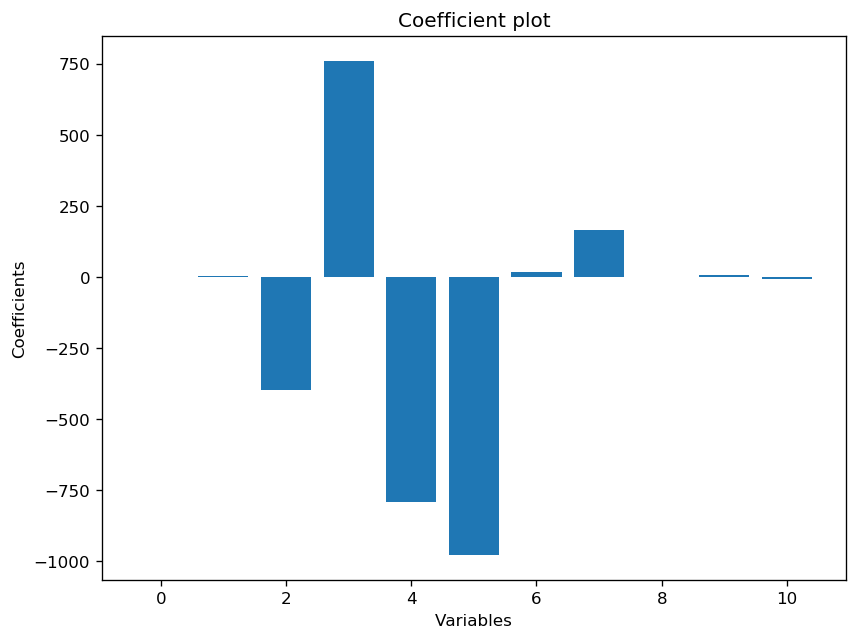

In [46]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

Here we can see that the model depends upon some independent variables quite a lot, but these coefficients are not suitable for interpretation because these are not scaled (not normalised), therefore we will perform the interpretation in this note book later.

## Checking assumptions of Linear Model

In [47]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']

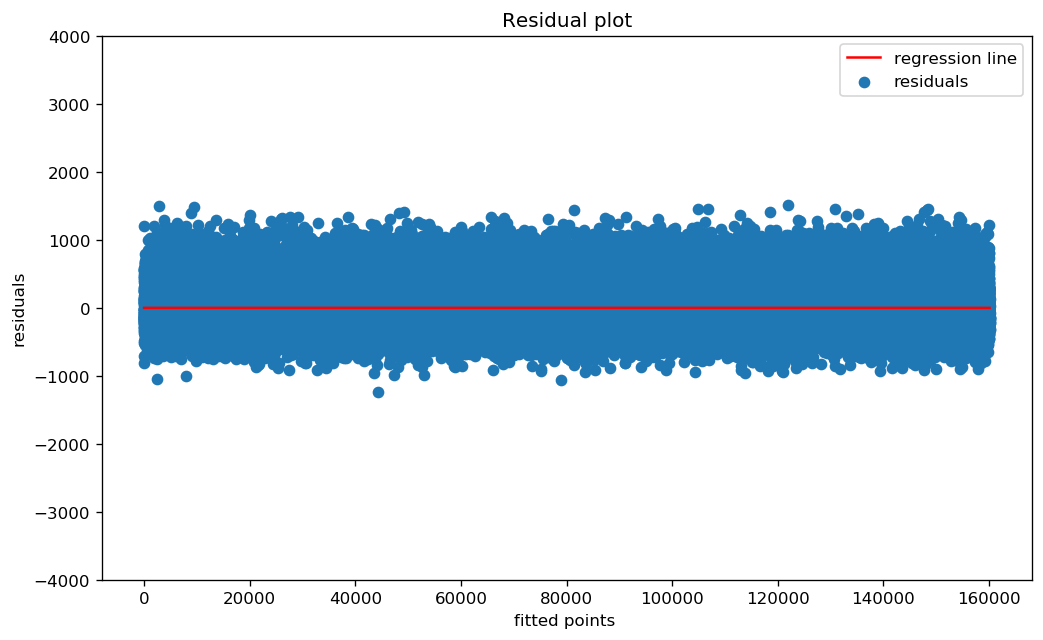

In [48]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,160121)
k = [0 for i in range(0,160121)]
plt.scatter(f, residuals.residuals[:], label = 'residuals')
plt.plot(f, k , color = 'red', label = 'regression line')
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-4000, 4000)
plt.legend()

The Residual plot clearly Looks Homoscedastic, i.e. the the variance of the error across the dataset is nearly constant (more on the positive side though).

### Checking Distribution of Residuals

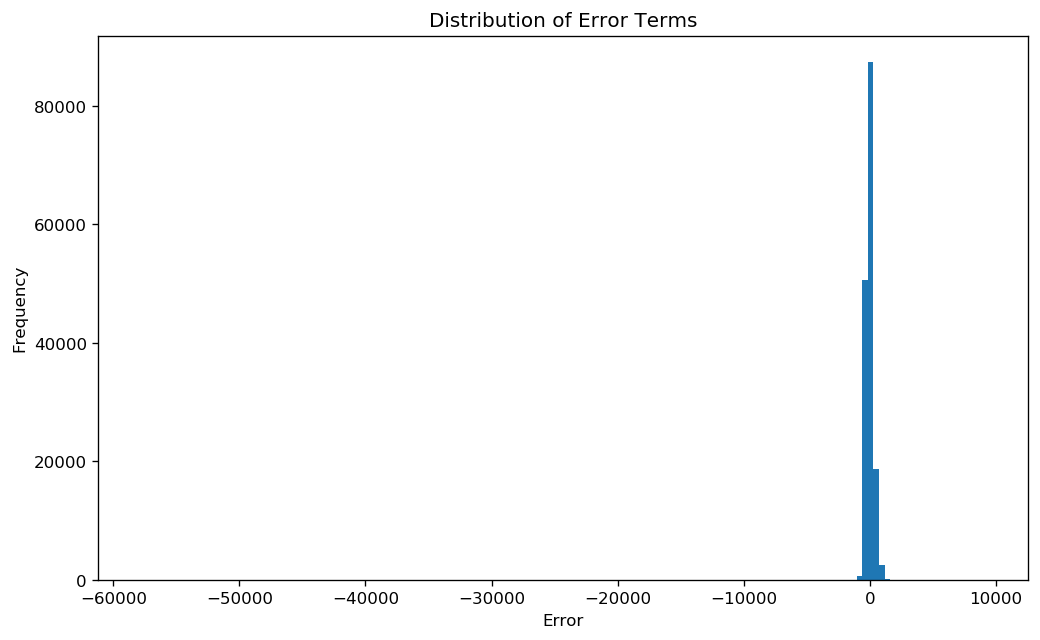

In [49]:
# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

According to the Histogram, the distribution of error is nearly normal, But there are some strong outliers on the negative end of the errors.

### QQ-Plot (Is the data Normally Distributed?)

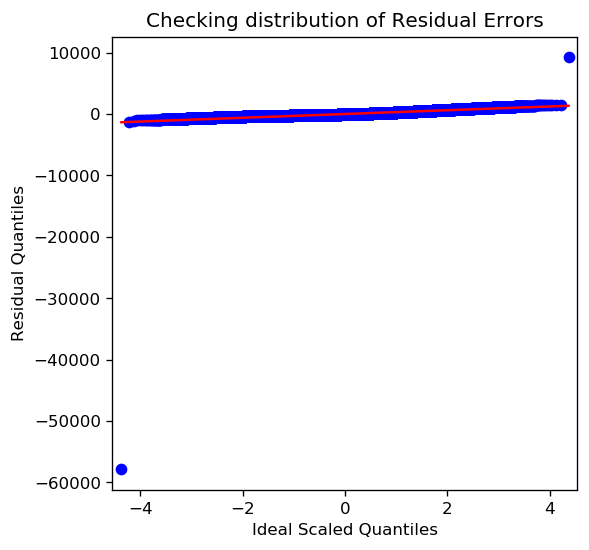

In [50]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

The QQ-plot clearly verifies our findings from the the histogram of the residuals, the data is mostly normal in nature, but there are some strong outliers on the higher end of the Residues.

From the ACF plot, we can clearly see that there is almost negligible correlation between the error terms. Hence there is no autocorrelation present in the data.

In [51]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF for every column (only works for the not Catagorical)
VIF = pd.Series([variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])], 
                index =df2.columns)
VIF

vendor_id             1.147511e+01
passenger_count       2.842100e+00
pickup_longitude      1.949454e+07
pickup_latitude       5.265997e+06
dropoff_longitude     1.966504e+07
dropoff_latitude      4.986065e+06
store_and_fwd_flag    1.010427e+00
trip_duration         7.897960e+00
distance in km        6.122174e+00
p_hour                5.587618e+01
d_hour                5.513890e+01
day                   5.383980e+00
dtype: float64

From this list, we clearly see that there happens to be some Independent Variable over the value of 5, which means that there are features that exhibit the Multicollinearity in the dataset.

## Model Interpretability

So far we have simply been predicting the values using the linear regression, But in order to Interpret the model, the normalising of the data is essential.

In [52]:
# Creating instance of Linear Regresssion
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [53]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 206.83481983546403


In [54]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error', k )

Test Mean Absolute Error 207.7292611915721


* These values were pre much exactly the same as the non-normalised values

Text(0.5, 1.0, 'Normalized Coefficient plot')

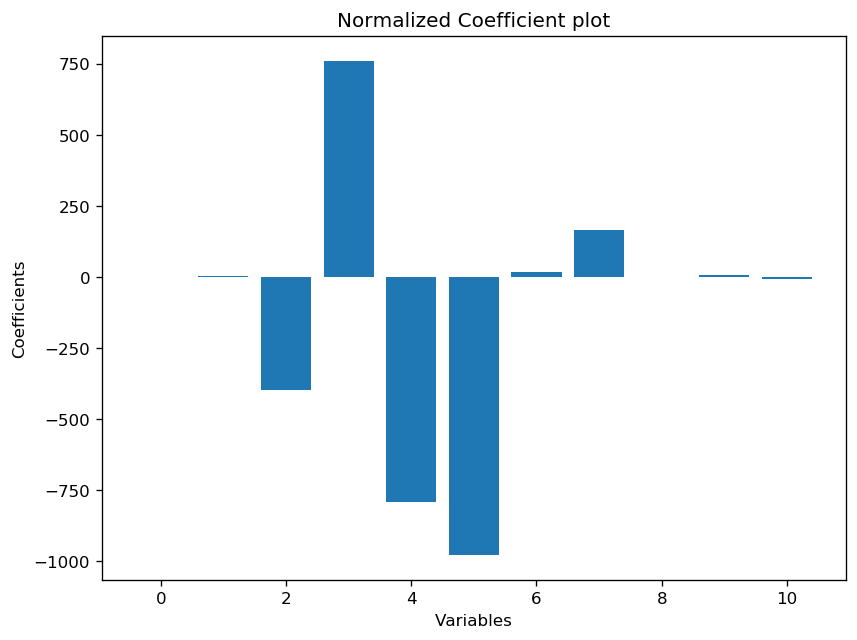

In [55]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

Now the coefficients we see are normalised and we can easily make final inferences out of it.

Here we can see that there are a lot of Coefficients which are near to zero and not Significant. So let us try removing them and build the model again.

In [56]:
#seperating independent and dependent variables
x = df2.drop(['trip_duration'], axis=1)
y = df2['trip_duration']
x.shape, y.shape

((640482, 11), (640482,))

In [57]:
# Arranging coefficients with features
Coefficients = pd.DataFrame({
    'Variable'    : x.columns,
    'coefficient' : lr.coef_
})
Coefficients

,Variable,coefficient
0,vendor_id,0.233589
1,passenger_count,2.193976
2,pickup_longitude,-400.586589
3,pickup_latitude,759.797564
4,dropoff_longitude,-794.726526
5,dropoff_latitude,-979.466146
6,store_and_fwd_flag,16.490811
7,distance in km,165.852924
8,p_hour,-2.453899
9,d_hour,6.236436


In [58]:
sig_var = Coefficients[Coefficients.coefficient > 0.5]

In [59]:
subset = df2[sig_var['Variable'].values]
subset

,passenger_count,pickup_latitude,store_and_fwd_flag,distance in km,d_hour
0,1,40.778873,0,1.199770,16
1,2,40.731743,0,4.123945,23
2,2,40.721458,0,7.250436,18
3,6,40.759720,0,2.358287,10
4,1,40.708469,0,4.328155,6
...,...,...,...,...,...
729317,2,40.789780,0,1.123068,13
729318,1,40.737434,0,0.728563,0
729319,1,40.761696,0,2.295919,19
729320,1,40.708244,0,0.846722,9


In [60]:
# Importing the train test split function
train_x,test_x,train_y,test_y = train_test_split(subset, y , random_state = 56)

In [61]:
# Creating instance of Linear Regresssion with Normalised Data
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [62]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 209.88495620011858


In [63]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error', k )

Test Mean Absolute Error 210.58503795770628


Text(0.5, 1.0, 'Normalized Coefficient plot')

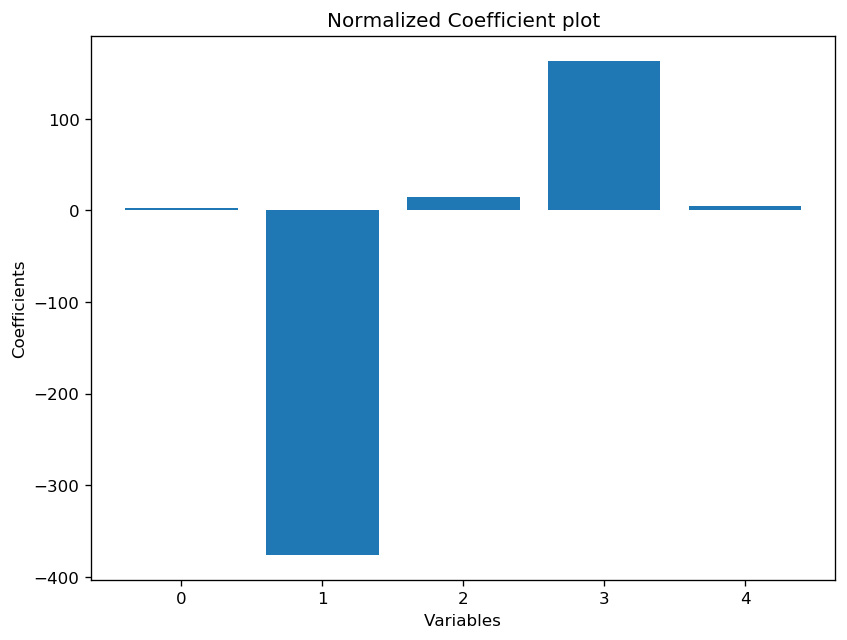

In [64]:
# Plotting the coefficients
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')